In [1]:
# 全局设置
import datetime as dt

import numpy as np
import pandas as pd

import QuantStudio.api as QS
fd = QS.FactorDB.FactorTools

HDB = QS.FactorDB.HDF5DB(config_file="../config/HDF5DBConfig.json").connect();

In [2]:
# 读取事件数据并形成事件因子
EventData = pd.read_excel("../Data/Excel/定增重组事件.xlsx",  sheet_name="Sheet1", header=0, index_col=None, usecols=[0, 2], dtype={"证券代码":"O"})
EventData["证券代码"] = [(iID+".SH" if iID[0] in ("6", "T") else iID+".SZ") for iID in EventData["证券代码"]]
EventData["首次公告日"] = [iDT.to_pydatetime() for iDT in EventData["首次公告日"]]
StartDT, EndDT = min(EventData["首次公告日"]), max(EventData["首次公告日"])
EventData = EventData.set_index(["首次公告日", "证券代码"])
EventData = EventData[~EventData.index.duplicated()]

FT = HDB.getTable("stock_cn_day_bar_nafilled")
DTs = FT.getDateTime(ifactor_name="close", start_dt=StartDT-dt.timedelta(365), end_dt=EndDT+dt.timedelta(31))
IDs = FT.getID(ifactor_name="close")

TradeStatus = FT.readData(factor_names=["if_trading"], ids=IDs, dts=DTs).iloc[0]
EventFactorData = pd.DataFrame(index=DTs, columns=IDs)
for iDT, iID in EventData.index:# 公告后的第一个正常交易日作为事件发生日
    iIdx = np.sum(TradeStatus.index<iDT)
    iIdx = np.arange(iIdx, TradeStatus.shape[0])[TradeStatus.loc[:, iID].iloc[iIdx:]==1]
    if iIdx.shape[0]==0: continue
    iIdx = iIdx[0]
    EventFactorData.loc[DTs[iIdx], iID] = 1

EventFactor = QS.FactorDB.DataFactor(name="定增重组事件", data=EventFactorData)

==========历史回测==========
1. 初始化


  0% (0 of 104) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

耗时 : 23.92
2. 循环计算


100% (104 of 104) |######################| Elapsed Time: 0:01:05 Time:  0:01:05


耗时 : 65.37
3. 结果生成
耗时 : 0.11
总耗时 : 89.40


,单时点,向前累积,向前向后累积
-3,0.3059,0.3059,0.1449
-2,0.3578,0.2735,0.1664
-1,0.2976,0.2194,0.1683
0,0.1950,0.1449,0.1950
1,0.0681,0.0620,0.0522
2,0.0344,0.0204,0.0107
3,0.4659,0.0296,0.0233
4,0.1447,0.0795,0.0951
5,0.1645,0.0569,0.0629
,单时点,向前累积,向前向后累积

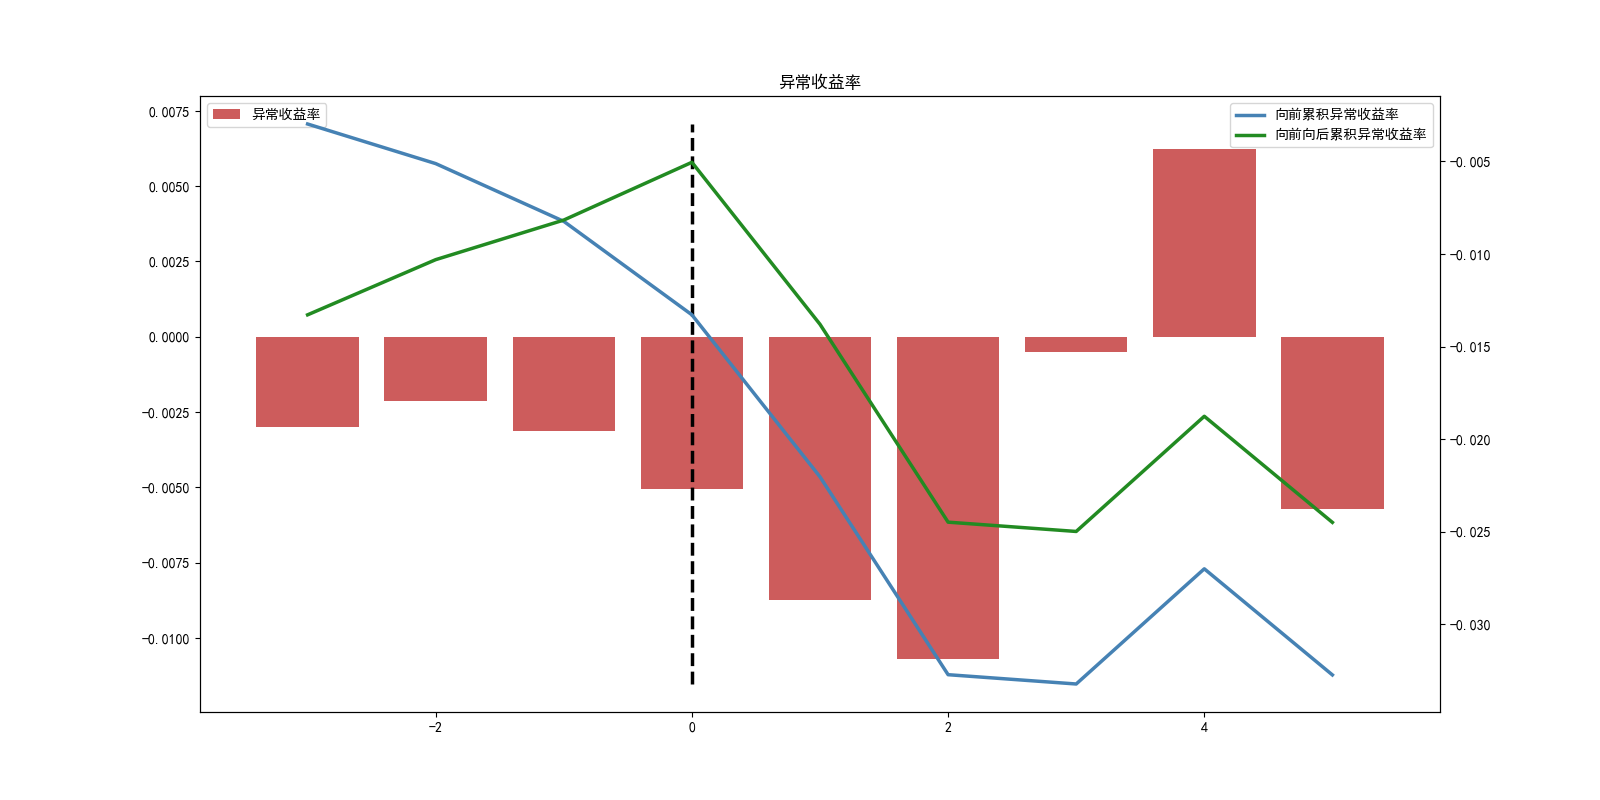
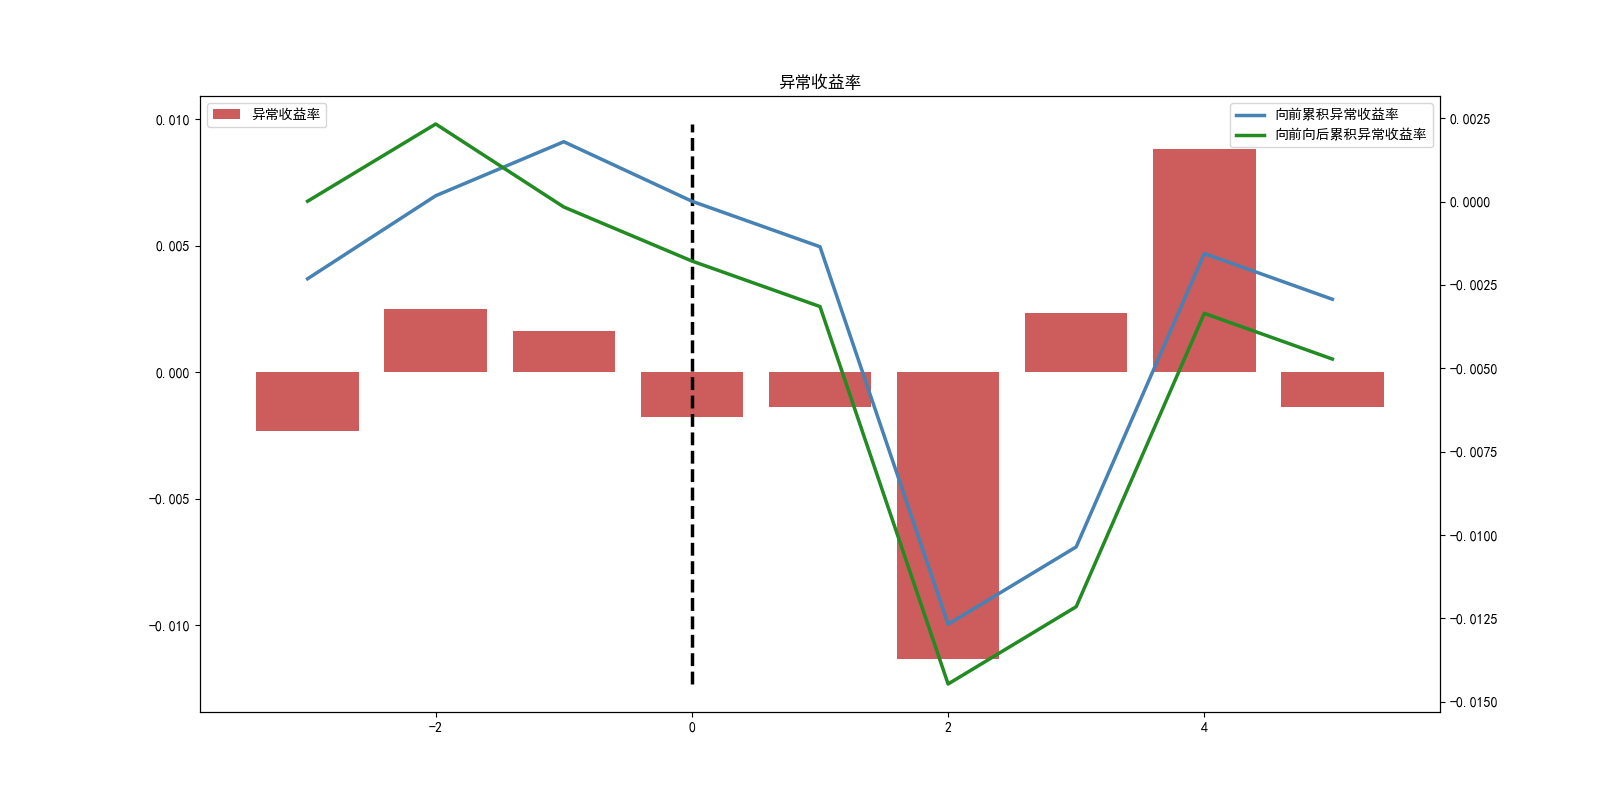
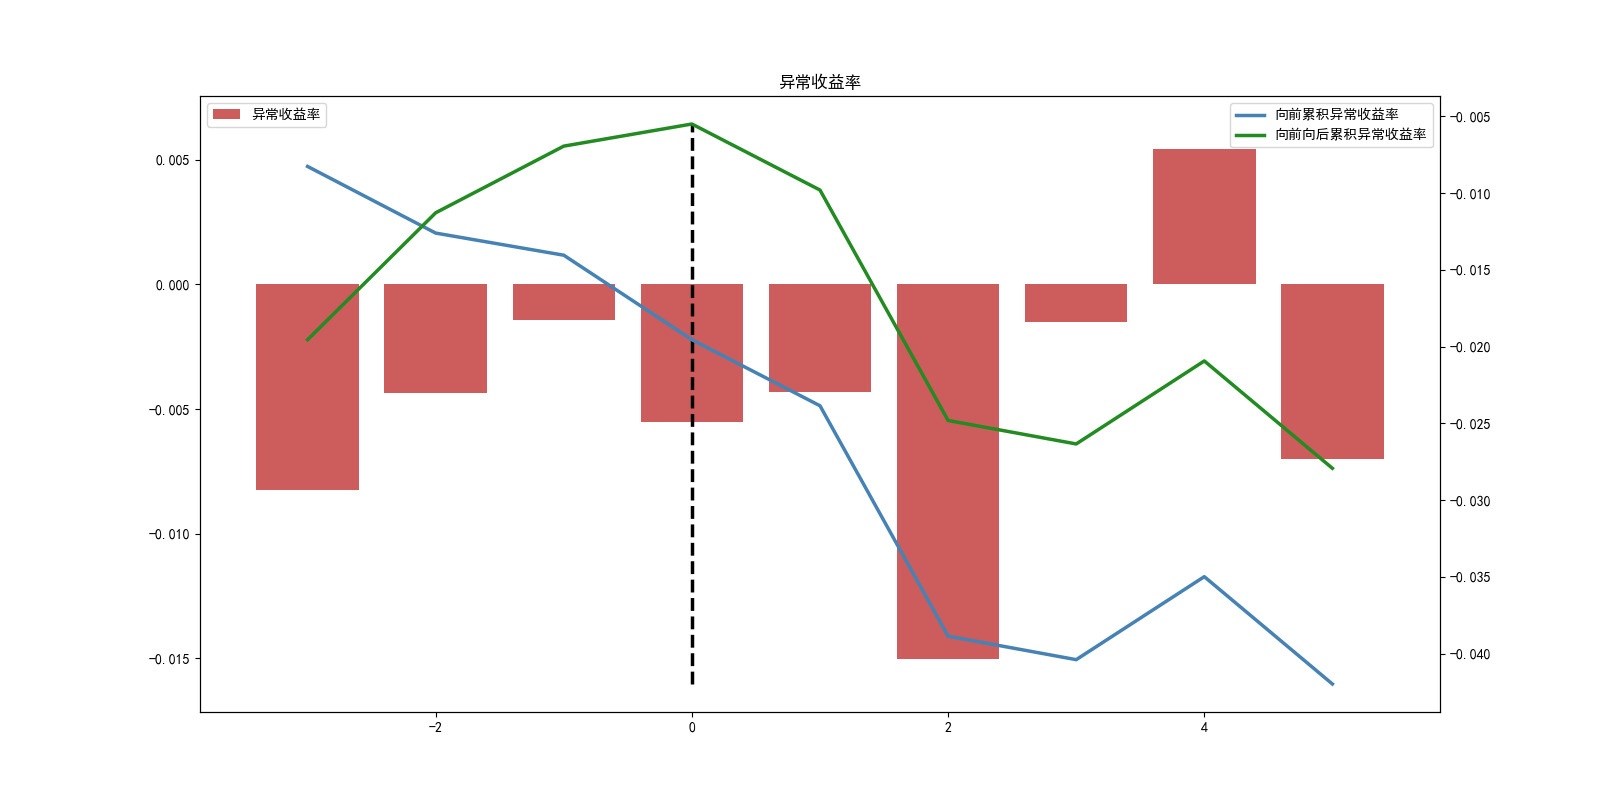

In [3]:
# 事件测试
# 创建自定义因子表
CFT = QS.FactorDB.CustomFT("CFT")
CFT.addFactors(factor_table=HDB.getTable("stock_cn_day_bar_adj_backward_nafilled"), factor_names=["close"], args={})
CFT.addFactors(factor_table=HDB.getTable("stock_cn_day_bar_nafilled"), factor_names=["if_trading"], args={})
CFT.addFactors(factor_list=[EventFactor])
CFT.setDateTime(DTs)
CFT.setID(IDs)

# 创建回测模型
Model = QS.BackTest.BackTestModel()
# --------事件测试模块--------
# 异常收益率均值常数模型
iModule = QS.BackTest.Event.CMRM(name="定增重组事件: 均值常数模型", factor_table=CFT)
iModule.Args["事件定义"] = "@定增重组事件==1"
iModule.Args["事件前窗口"] = 3
iModule.Args["事件后窗口"] = 5
iModule.Args["价格因子"] = "close"
iModule.Args["收益率类型"] = "简单收益率"
iModule.Args["估计窗口"] = 240
iModule.Args["样本筛选"] = "@if_trading==1"
iModule.Args["估计样本量"] = 20
Model.Modules.append(iModule)
# 异常收益率市场调整模型
iModule = QS.BackTest.Event.MAM(name="定增重组事件: 市场调整模型", factor_table=CFT, benchmark_ft=HDB.getTable("index_cn_day_bar"))
iModule.Args["事件定义"] = "@定增重组事件==1"
iModule.Args["事件前窗口"] = 3
iModule.Args["事件后窗口"] = 5
iModule.Args["价格因子"] = "close"
iModule.Args["收益率类型"] = "简单收益率"
iModule.Args["估计窗口"] = 240
iModule.Args["样本筛选"] = "@if_trading==1"
iModule.Args["估计样本量"] = 20
iModule.Args["基准价格"] = "close"
iModule.Args["基准ID"] = "000300.SH"
Model.Modules.append(iModule)
# 异常收益率市场模型
iModule = QS.BackTest.Event.MM(name="定增重组事件: 市场模型", factor_table=CFT, benchmark_ft=HDB.getTable("index_cn_day_bar"))
iModule.Args["事件定义"] = "@定增重组事件==1"
iModule.Args["事件前窗口"] = 3
iModule.Args["事件后窗口"] = 5
iModule.Args["价格因子"] = "close"
iModule.Args["收益率类型"] = "简单收益率"
iModule.Args["估计窗口"] = 240
iModule.Args["样本筛选"] = "@if_trading==1"
iModule.Args["估计样本量"] = 20
iModule.Args["基准价格"] = "close"
iModule.Args["基准ID"] = "000300.SH"
Model.Modules.append(iModule)

# 运行模型
Model.run(dts=DTs[240:])

# 查看结果
display(Model)